In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re


In [27]:
# Load the CSV file into a DataFrame
file_path = r"~\OneDrive\Documents\Capstone\EDA\combined_feb_2022_data.csv"  # Adjust the path if needed
df_anonymized = pd.read_csv(file_path)

# Display all columns
pd.set_option('display.max_columns', None)

# Display the first few rows of the DataFrame
df_anonymized.sample(1)


,PRODUCT DESCRIPTION,CONSIGNEE,SHIPPER,ARRIVAL DATE,GROSS WEIGHT (LB),GROSS WEIGHT (KG),FOREIGN PORT,US PORT,VESSEL NAME,COUNTRY OF ORIGIN,MARKS &AMP; NUMBERS,CONSIGNEE ADDRESS,SHIPPER ADDRESS,ZIP CODE,NO. OF CONTAINERS,CONTAINER NUMBER,CONTAINER TYPE,QUANTITY,QUANTITY UNIT,MEASUREMENT,MEASUREMENT UNIT,BILL OF LADING,HOUSE VS MASTER,DISTRIBUTION PORT,MASTER B/L,VOYAGE NUMBER,SEAL,SHIP REGISTERED IN,IN-BOND ENTRY TYPE,CARRIER CODE,CARRIER NAME,CARRIER CITY,CARRIER STATE,CARRIER ZIP,CARRIER ADDRESS,NOTIFY PARTY,NOTIFY ADDRESS,PLACE OF RECEIPT
148460,"LADIES 91% RECYCLED POLYESTER 9%SPANDEX CARDIGAN LADIES' 95% RAYON 5%SPANDEX KNIT FULLOVER LADIES 51% COTTON 23% POLYESTER 14% LYOCELL 10% RAYON 2% SPANDEX BLACK WOVEN DENIM PANT LADIES 94% LYOCELL 6% SPANDEXKNITTED PULLOVERLADIES 91% RECYCLED POLYESTER 9%, SPANDEX KNITTED PULLOVER LADIES 100% MODAL KNITTED PULLOVER LADIES 76% COTTON 23% RECYCLEDPOLYESTER 1% SPANDEX WOVEN JACKET LADIES 100% MODAL KNITTED CARDIGAN",AMANZI WHOLESALE,DEUTSCHE BEKLEIDUNGSWERKE LIMITED,2022-02-11,1087,494,Vung Tau,"New York/Newark Area, Newark, New Jersey",YM WELLHEAD,Vietnam,CEL-ETC,300 W VALLEY BLVD ALHAMBRA CA 91803 US,PLOT P-1A ROAD NUMBER 6 LONG HAU EXPANSION AREA LONG HAU COMMUNE LONG AN VN,91803,1,TCLU8420184,,28 CTN,CTN,0,,NAQATNYC130177V,H,,ONEYSGNBBQ051400,033E,VN1464288A,HONG KONG,,NAQA,NACA (VANGUARD LOGISTICS SERVICES),CARSON,CA,90745-5003,857 E 230TH ST,CARLISLE ETCETERA DISTRIBUTION CENT,1200 INDEPENDENCE WAY,HO CHI MINH


In [3]:
df_anonymized.shape

(316813, 38)

In [4]:
# Count the number of unique US ports in the 'US PORT' column
unique_us_ports_count = df_anonymized['US PORT'].unique()

# Display the result
unique_us_ports_count


array(['New York/Newark Area, Newark, New Jersey', 'New York, New York',
       'New Orleans, Louisiana', 'Portsmouth, New Hampshire',
       'New Haven, Connecticut', 'UPS, Newark, New Jersey',
       'Perth Amboy, New Jersey', 'Albany, New York',
       'Camden, New Jersey'], dtype=object)

In [5]:
# List of ports to keep
ports_to_keep = ['New York/Newark Area, Newark, New Jersey', 'New York, New York']

# Create a DataFrame with the rows that do not match the specified ports (to move them to a different DataFrame)
other_ports_df = df_anonymized[~df_anonymized['US PORT'].isin(ports_to_keep)]

# Keep only the rows that match the specified ports in the original DataFrame
df_anonymized = df_anonymized[df_anonymized['US PORT'].isin(ports_to_keep)]

# Display the number of rows in each DataFrame
print(f"Number of rows for New York ports (df_anonymized): {len(df_anonymized)}")
print(f"Number of rows for other ports (other_ports_df): {len(other_ports_df)}")



Number of rows for New York ports (df_anonymized): 311259
Number of rows for other ports (other_ports_df): 5554


In [6]:
# Create a new DataFrame for rows where 'PRODUCT DESCRIPTION' contains the word "empty container"

# Ensure that 'PRODUCT DESCRIPTION' is a string (handle possible NaN)
df_anonymized['PRODUCT DESCRIPTION'] = df_anonymized['PRODUCT DESCRIPTION'].astype(str)

# Create a new DataFrame for rows where 'PRODUCT DESCRIPTION' contains:
# 1. The exact phrase "empty container"
# 2. Only the word "EMPTY" repeated, like "EMPTY EMPTY EMPTY..."
empty_container_df = df_anonymized[
    df_anonymized['PRODUCT DESCRIPTION'].str.contains(r'\bempty container\b', case=False, na=False) |
    df_anonymized['PRODUCT DESCRIPTION'].str.contains(r'\bempty equipment\b', case=False, na=False) |
    df_anonymized['PRODUCT DESCRIPTION'].str.match(r'^\s*(EMPTY\s*)+$', case=False)
]

# Remove those rows from the original DataFrame
df_anonymized = df_anonymized[
    ~(df_anonymized['PRODUCT DESCRIPTION'].str.contains(r'\bempty container\b', case=False, na=False) |
    df_anonymized['PRODUCT DESCRIPTION'].str.contains(r'\bempty equipment\b', case=False, na=False) |
    df_anonymized['PRODUCT DESCRIPTION'].str.match(r'^\s*(EMPTY\s*)+$', case=False))
]

# Verify that the rows containing "empty container" or "EMPTY EMPTY..." have been moved
print(f"Number of 'empty container' or 'EMPTY' product descriptions: {len(empty_container_df)}")
print(f"Number of non-empty product descriptions: {len(df_anonymized)}")

#empty_container_df.head()


Number of 'empty container' or 'EMPTY' product descriptions: 48
Number of non-empty product descriptions: 311211


In [7]:
# Define a function to check if 'PRODUCT DESCRIPTION' contains words
def contains_words(description):
    if isinstance(description, str):  # Ensure it's a string
        return bool(re.search(r'[a-zA-Z]', description))  # Check for alphabetic characters (A-Z or a-z)
    return False

# Create a DataFrame for rows where 'PRODUCT DESCRIPTION' contains non-words
non_word_descriptions_df = df_anonymized[~df_anonymized['PRODUCT DESCRIPTION'].apply(contains_words)]

# Create a DataFrame for rows where 'PRODUCT DESCRIPTION' contains words
df_anonymized = df_anonymized[df_anonymized['PRODUCT DESCRIPTION'].apply(contains_words)]

# Display the number of rows in each DataFrame
print(f"Number of rows with valid word descriptions: {len(df_anonymized)}")
print(f"Number of rows with non-word descriptions: {len(non_word_descriptions_df)}")

#non_word_descriptions_df


Number of rows with valid word descriptions: 311163
Number of rows with non-word descriptions: 48


In [8]:
# Function to extract numeric values from the 'QUANTITY' column
def extract_numeric_quantity(quantity):
    if isinstance(quantity, str):  # Ensure it's a string
        match = re.search(r'\d+', quantity)  # Find the first sequence of digits
        if match:
            return int(match.group())  # Return the numeric value as an integer
    return quantity  # If no match, return the original value (likely NaN)

# Apply the function to extract numeric values in 'QUANTITY'
df_anonymized['QUANTITY'] = df_anonymized['QUANTITY'].apply(extract_numeric_quantity)

# Convert 'NO. OF CONTAINERS' to numeric to avoid issues
df_anonymized['NO. OF CONTAINERS'] = pd.to_numeric(df_anonymized['NO. OF CONTAINERS'], errors='coerce')


# Display all examples where 'NO. OF CONTAINERS' > 1, 'QUANTITY UNIT' is not 'CNT', and 'NO. OF CONTAINERS' equals 'QUANTITY'
examples_to_fix_df = df_anonymized[(df_anonymized['NO. OF CONTAINERS'] > 1) & 
                                   (df_anonymized['QUANTITY UNIT'] != 'CNT') & 
                                   (df_anonymized['NO. OF CONTAINERS'] == df_anonymized['QUANTITY'])]

# Display only rows where 'NO. OF CONTAINERS' > 50 from the examples_to_fix_df
large_container_rows = examples_to_fix_df[examples_to_fix_df['NO. OF CONTAINERS'] > 50]

# Display the filtered rows
large_container_rows.head()



,PRODUCT DESCRIPTION,CONSIGNEE,SHIPPER,ARRIVAL DATE,GROSS WEIGHT (LB),GROSS WEIGHT (KG),FOREIGN PORT,US PORT,VESSEL NAME,COUNTRY OF ORIGIN,...,IN-BOND ENTRY TYPE,CARRIER CODE,CARRIER NAME,CARRIER CITY,CARRIER STATE,CARRIER ZIP,CARRIER ADDRESS,NOTIFY PARTY,NOTIFY ADDRESS,PLACE OF RECEIPT
38881,EMPTY CONTAINERS USED FOR REPOSITIONING PURPOO...,CMA CGM ANL (NZ) LTD,CMA CGM (UK) SHIPPING LIMITED,2022-02-05,757614,344370,Felixstowe,"New York/Newark Area, Newark, New Jersey",SEATRADE GREEN,United Kingdom,...,,CMDU,COMPAGNIE MARITIME D-AFFRETEMENT,NORFOLK,VA,23502,5701 LAKE WRIGHT DR,CMA CGM ANL (NZ) LTD,"LEVEL 7, ST JOHN HOUSE 114 THE TERRACE WELLINGTON",FELIXSTOWE
266181,EMPTY CONTAINERS USED FOR REPOSITIONING PURPOO...,CMA CGM ANL (NZ) LTD,CMA CGM (UK) SHIPPING LIMITED,2022-02-17,707916,321780,Felixstowe,"New York/Newark Area, Newark, New Jersey",CMA CGM ABU DHABI,United Kingdom,...,,CMDU,COMPAGNIE MARITIME D-AFFRETEMENT,NORFOLK,VA,23502,5701 LAKE WRIGHT DR,CMA CGM ANL (NZ) LTD,"LEVEL 7, ST JOHN HOUSE 114 THE TERRACE WELLINGTON",FELIXSTOWE
309055,EMPTY REPOSITIONING CONTAINER NON OPERATING RE...,CMA-CGM GROUP AGENCIES (NZ) LTD,CMA CGM AGENCES FRANCE SAS,2022-02-24,756215,343734,Dunkirk,"New York/Newark Area, Newark, New Jersey",MANDALAY,France,...,,CMDU,COMPAGNIE MARITIME D-AFFRETEMENT,NORFOLK,VA,23502,5701 LAKE WRIGHT DR,CMA-CGM GROUP AGENCIES (NZ) LTD,PO BOX 4093 SHORTLAND STREET AUCKLAND,DUNKERQUE


In [9]:
# Define the custom function to identify rows that satisfy the condition
def fix_no_of_containers(row):
    if row['NO. OF CONTAINERS'] > 1 and row['QUANTITY UNIT'] != 'CNT' and row['NO. OF CONTAINERS'] == row['QUANTITY']:
        return True  # The condition is met
    return False  # Otherwise, the condition is not met

# Apply the function to each row to create a new column 'Condition Met'
df_anonymized['Condition Met'] = df_anonymized.apply(fix_no_of_containers, axis=1)

# Filter the DataFrame for rows that meet the condition
filtered_df = df_anonymized[df_anonymized['Condition Met'] == True]

# Print the filtered DataFrame
print(f"Rows that satisfy the condition: {len(filtered_df)}")
#filtered_df.head()

Rows that satisfy the condition: 859


In [10]:
# Apply the function to fix 'NO. OF CONTAINERS'
# df_anonymized['NO. OF CONTAINERS'] = df_anonymized.apply(fix_no_of_containers, axis=1)

Standard ISO 6346 Container Code:

ISO 6346 is the international standard for identifying intermodal containers, and the codes typically follow a structure where each part of the code represents certain characteristics of the container:

- First two digits (or numbers) often represent the container length and height.
- Next character (letter) generally indicates the type of container (e.g., open top, refrigerated).
- Last digit might represent additional features or specifications.

First digit: refers to the length of the container. In the ISO standard, containers are commonly categorized as:

- 2 → 20-foot container
- 4 → 40-foot container
- 5 → 45-foot container

### Note: still have to serperate reefers

In [11]:
# Remove any leading or trailing spaces from 'CONTAINER TYPE'
df_anonymized['CONTAINER TYPE'] = df_anonymized['CONTAINER TYPE'].str.strip()

# Expand the lists of common ISO codes for each container length
# Expanded lists of common ISO codes for each container length
iso_codes_20ft = ['20G1', '22G1', '22G0', '2200', '22U1', '2CT2', '2210', '2CG0', '20B0', '2CB0', '2CT0', '25G0',
                  '2273', '2270', '20G0', '2232', '20U0', '2251', '2250', '2230', '2510', '20FT', '22U0']  # Expanded for 20-foot containers

iso_codes_40ft = ['40G1', '42G1', '45G1', '40G0', '42G0', '45G0', '4500', '4510', '45U1', '4EB0', '4400', '45R0',
                  '4EG0', '4310', '4200', '4RE0', '4FR0', '4NG0', '4FG0', '45R1', '4ER0', '4CB0', '40R0', '4CR0', 
                  '4CG0', '4300', '4505', '40U0', '4209', '45G2', '4209', '4351', '44G0', '40B0', '42G9', '4432',
                  '4250', '4000', '4232', '45R5', '42T0', '4530', '45B0', '4530', '40FT', '40H0', '42U0']  # Expanded for 40-foot containers

iso_codes_45ft = ['L5G1', 'L5G0', 'L5G4','L5U1', '45G0', 'LFG0', 'LEB0', 'LEG0', 'LCG0', '9400', '9500']  # Existing 45-foot codes (expanded slightly)

iso_codes_53ft = ['53G1', '53G0', '5300', '4532']  # Added more for 53-foot containers


# Define a function to map the container type based on specific ISO codes
def map_container_length(container_type):
    if isinstance(container_type, str):
        container_type = container_type.upper()  # Ensure it's in uppercase for consistency
        
        # Check for 20ft container codes
        if any(code in container_type for code in iso_codes_20ft):
            return '20'  # 20-foot container
        
        # Check for 40ft container codes
        elif any(code in container_type for code in iso_codes_40ft):
            return '40'  # 40-foot container
        
        # Check for 45ft container codes
        elif any(code in container_type for code in iso_codes_45ft):
            return '45'  # 45-foot container
        
        # Check for 53ft container codes
        elif any(code in container_type for code in iso_codes_53ft):
            return '53'  # 53-foot container
        
        else:
            return 'other'  # If no match, classify as 'other'
    return 'other'  # Handle non-string cases

# Apply the function to create the new 'CONTAINER LENGTH' column
df_anonymized['CONTAINER LENGTH'] = df_anonymized['CONTAINER TYPE'].apply(map_container_length)

# Display the updated DataFrame
print(df_anonymized[['CONTAINER TYPE', 'CONTAINER LENGTH']].head())


  CONTAINER TYPE CONTAINER LENGTH
0           45G0               40
1           45G0               40
2           45G0               40
3           45G0               40
4           45G0               40


In [12]:
df_anonymized.shape

(311163, 40)

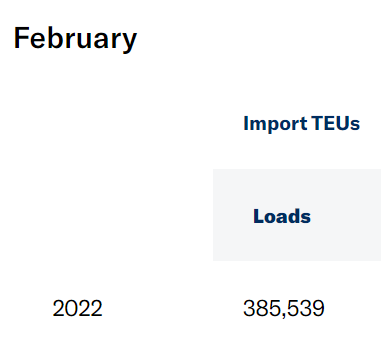

source: https://www.panynj.gov/port/en/our-port/facts-and-figures.html

In [13]:
# Check for duplicate rows
print(df_anonymized.duplicated().sum())

# Optionally, drop duplicates
df_anonymized = df_anonymized.drop_duplicates()

0


In [14]:
# Get the unique container numbers
unique_containers = df_anonymized['CONTAINER NUMBER'].unique()

# Count the unique container numbers
num_unique_containers = len(unique_containers)

print(f"Total rows with unique container values: {num_unique_containers}")


Total rows with unique container values: 167436


In [15]:
# Drop duplicates based on the 'CONTAINER NUMBER' column
df_anonymized = df_anonymized.drop_duplicates(subset=['CONTAINER NUMBER'])

df_anonymized.shape

(167436, 40)

In [16]:
# Count the occurrences of each value in the 'CONTAINER LENGTH' column
container_length_counts = df_anonymized['CONTAINER LENGTH'].value_counts()

# Display the counts for '20', '40', '50', and 'other'
print(f"Container Length Counts:\n{container_length_counts}")

Container Length Counts:
CONTAINER LENGTH
40       120408
20        27116
other     13606
53         4859
45         1447
Name: count, dtype: int64


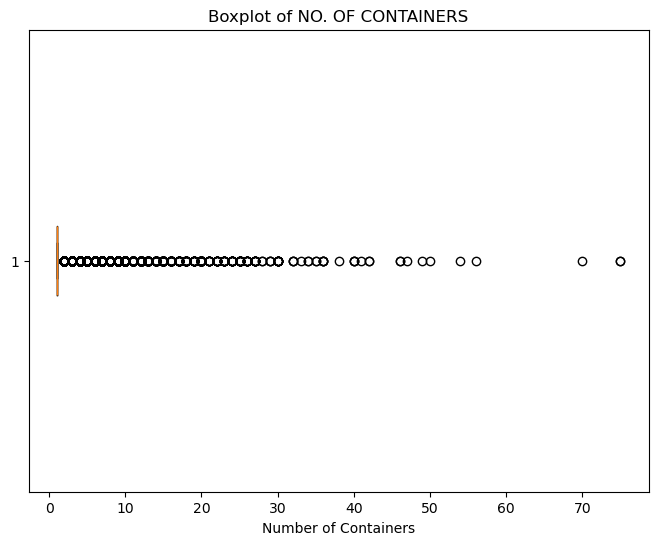

In [17]:
# Create a boxplot to visualize the 'NO. OF CONTAINERS' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_anonymized['NO. OF CONTAINERS'].dropna(), vert=False)
plt.title('Boxplot of NO. OF CONTAINERS')
plt.xlabel('Number of Containers')

# Display the plot
plt.show()


In [18]:
import re

# Step 1: Define the regex pattern for the container number format (XXXX#######)
container_number_pattern = re.compile(r'^[A-Z]{4}\d{7}$')

# Step 2: Ensure 'CONTAINER NUMBER' column is treated as strings (handle NaNs by filling with empty strings)
df_anonymized['CONTAINER NUMBER'] = df_anonymized['CONTAINER NUMBER'].fillna('').astype(str)

# Step 3: Split the 'CONTAINER NUMBER' column by spaces into a list of container numbers
df_anonymized['CONTAINER NUMBER LIST'] = df_anonymized['CONTAINER NUMBER'].str.split()

# Step 4: Extract valid container numbers and create a new column for valid ones
df_anonymized['VALID CONTAINER LIST'] = df_anonymized['CONTAINER NUMBER LIST'].apply(
    lambda containers: [c for c in containers if re.match(container_number_pattern, c)]
)

# Step 5: Filter rows where 'VALID CONTAINER LIST' is not empty
df_anonymized = df_anonymized[df_anonymized['VALID CONTAINER LIST'].str.len() > 0]

# Step 6: Explode the 'VALID CONTAINER LIST' into separate rows while keeping all original columns
df_extracted_containers = df_anonymized.explode('VALID CONTAINER LIST', ignore_index=True)

# Rename the exploded column to 'CONTAINER NUMBER'
df_extracted_containers = df_extracted_containers.rename(columns={'VALID CONTAINER LIST': 'CONTAINER NUMBER'})

# Step 7: Drop duplicates in the exploded DataFrame
df_extracted_containers = df_extracted_containers.drop_duplicates(subset=['CONTAINER NUMBER'])

# Step 8: Find and print duplicated container numbers
duplicates = df_extracted_containers[df_extracted_containers.duplicated(subset=['CONTAINER NUMBER'], keep=False)]

# Check if there are any duplicates
if not duplicates.empty:
    print("Duplicate container numbers found:")
    print(duplicates['CONTAINER NUMBER'].value_counts())
else:
    print("No duplicate container numbers found.")

# Step 9: Count the unique container numbers by 'CONTAINER LENGTH'
container_type_counts = df_extracted_containers.groupby('CONTAINER LENGTH')['CONTAINER NUMBER'].nunique()

# Print the counts of container numbers for each container length
print("\nContainer counts by container length (after removing duplicates):")
print(container_type_counts)


# Optionally: Save the result to a CSV file for further inspection
# df_extracted_containers.to_csv('extracted_container_numbers.csv', index=False)

# Optionally: Print the extracted DataFrame for inspection
# print(df_extracted_containers.head())


No duplicate container numbers found.

Container counts by container length (after removing duplicates):
                  CONTAINER NUMBER  CONTAINER NUMBER
CONTAINER LENGTH                                    
20                           27116             44944
40                          120403            170623
45                            1447              1606
53                            4859              5548
other                        13599             17430


In [19]:
# Step 7: Drop duplicates based on 'CONTAINER NUMBER'
df_extracted_containers = df_extracted_containers.drop_duplicates(subset=['CONTAINER NUMBER'])

# Step 8: Count the container numbers by 'CONTAINER LENGTH'
container_type_counts = df_extracted_containers.groupby('CONTAINER LENGTH')['CONTAINER NUMBER'].count()

# Step 9: Count the unique container numbers by 'CONTAINER LENGTH'
container_type_counts = df_extracted_containers.groupby('CONTAINER LENGTH')['CONTAINER NUMBER'].nunique()

# Print the counts of container numbers for each container length
print("\nContainer counts by container length (after removing duplicates):")
print(container_type_counts)




Container counts by container length (after removing duplicates):
                  CONTAINER NUMBER  CONTAINER NUMBER
CONTAINER LENGTH                                    
20                           27116             44944
40                          120403            170623
45                            1447              1606
53                            4859              5548
other                        13599             17430


In [20]:
df_extracted_containers.head()

,PRODUCT DESCRIPTION,CONSIGNEE,SHIPPER,ARRIVAL DATE,GROSS WEIGHT (LB),GROSS WEIGHT (KG),FOREIGN PORT,US PORT,VESSEL NAME,COUNTRY OF ORIGIN,...,CARRIER STATE,CARRIER ZIP,CARRIER ADDRESS,NOTIFY PARTY,NOTIFY ADDRESS,PLACE OF RECEIPT,Condition Met,CONTAINER LENGTH,CONTAINER NUMBER LIST,CONTAINER NUMBER
0,COMMON-RAILHS-CODE: 84099990RYDER LOAD #51155072,HARDINGER (SOUTH) WAREHOUSE,NOVA WERKE AG,2022-02-08,1892,860,Bremerhaven,"New York/Newark Area, Newark, New Jersey",COSCO PHILIPPINES,Germany,...,,,,-NOT AVAILABLE-,-NOT AVAILABLE-,BREMERHAVEN,False,40,[CSNU7433954],CSNU7433954
1,POLYESTER FILM,WEB PLASTICS COMPANY,JBF BAHRAIN W.L.L.,2022-02-08,43380,19718,Valencia,"New York, New York",CHICAGO EXPRESS,Spain,...,NJ,07102,33 WASHINGTON ST - 14TH FL,WEB PLASTICS COMPANY.,1414 SUSQUEHANNA AVE,BAHRAIN,False,40,[HLBU3135426],HLBU3135426
2,04 BALES SAID TO CONTAIN 100 PERCENT COTTON YA...,LEE JOFA (A UNIT OF KRAVET INC),AMBADI ENTERPRISES LTD. [CHENNAI],2022-02-08,167,76,Colombo,"New York, New York",CMA CGM A. LINCOLN,Sri Lanka,...,NY,11413,230-59 INTERNATIONAL AIRPORT CENTER BLVD SUITE...,-NOT AVAILABLE-,-NOT AVAILABLE-,CHENNAI,False,other,[CMAU7809558],CMAU7809558
3,POLYESTER FILM (PET FILM) POLYESTER FILM (PET ...,"CAPRI PACKAGING, TC TRANSCONTINENTA",JBF BAHRAIN W.L.L.,2022-02-08,84115,38234,Valencia,"New York, New York",CHICAGO EXPRESS,Spain,...,NJ,07102,33 WASHINGTON ST - 14TH FL,BEST WAY DISTRIBUTION,13209 ARRINGTON ROAD,BAHRAIN,False,40,"[HLBU2141152, HAMU1214151]",HLBU2141152
4,POLYESTER FILM (PET FILM) POLYESTER FILM (PET ...,"CAPRI PACKAGING, TC TRANSCONTINENTA",JBF BAHRAIN W.L.L.,2022-02-08,84115,38234,Valencia,"New York, New York",CHICAGO EXPRESS,Spain,...,NJ,07102,33 WASHINGTON ST - 14TH FL,BEST WAY DISTRIBUTION,13209 ARRINGTON ROAD,BAHRAIN,False,40,"[HLBU2141152, HAMU1214151]",HAMU1214151


In [21]:
# Define the multipliers for each container length
multipliers = {
    '20': 1,       # 20-foot containers = 1 TEU
    '40': 2,       # 40-foot containers = 2 TEUs
    '45': 2,       # 45-foot containers = 2 TEUs
    '53': 2.65,    # 53-foot containers = 2.65 TEUs (commonly used estimate)
    'other': 1     # 'other' containers treated as 20-foot containers = 1 TEU
}

# Calculate the total TEUs by multiplying the container counts with the multipliers
total_teus = (
    container_type_counts['20'] * multipliers['20'] +
    container_type_counts['40'] * multipliers['40'] +
    container_type_counts['45'] * multipliers['45'] +
    container_type_counts['53'] * multipliers['53'] +
    container_type_counts['other'] * multipliers['other']
)

# Display the total TEUs
print(f"Total TEUs: {total_teus}")

KeyError: '20'

In [ ]:
percentageTEUs = total_teus/385539 * 100
print(f"We have {percentageTEUs}% of the PANYNJ listed import TEUs accounted for")

We have more TEUs in the ImportGenius data than listed by PANYNJ.

There is a roughly 10% discrepancy.

In [28]:
df_extracted_containers['Has Postal Code'] = df_extracted_containers['CONSIGNEE ADDRESS'].str.contains(r'(?<!\d)\d{5}(?!\d)', na=False)
postal_code_count = df_extracted_containers['Has Postal Code'].sum()

postal_code_count

149257

Postal codes sourced from: https://www.lehighvalleyelitenetwork.com/lehigh-valley-zip-codes

In [31]:
# Define the postal codes we want to search for
target_postal_codes = {
    # Lehigh Valley
    '18010', '18011', '18067', '18101', '18102', '18103', '18104', '18105', 
    '18106', '18109', '18175', '18195', '18013', '18014', '18015', '18016', 
    '18017', '18018', '18020', '18045', '18025', '18031', '18064', '18065', 
    '18091', '18032', '18034', '18035', '18042', '18036', '18037', '18038', 
    '18040', '18015', '18017', '18043', '18044', '18045', '18046', '18049', 
    '18098', '18099', '18050', '18051', '18053', '18066', '18055', '18052', 
    '18059', '18035', '18038', '18067', '18086', '18088', '18060', '18051', 
    '18066', '18069', '18078', '18015', '18055', '18062', '18063', '18036', 
    '18041', '18049', '18062', '18092', '18014', '18038', '18064', '18067', 
    '18343', '18064', '18065', '18066', '18068', '18069', '18072', '18351', 
    '18013', '18015', '18049', '18103', '18104', '18193', '18078', '18079', 
    '18080', '18083', '18085', '18086', '18087', '18015', '18034', '18036', 
    '18088', '18078', '18079', '18080', '18031', '18051', '18066', '19529', 
    '18052', '18053', '18069', '18103', '18104', '18042', '18091', '18092'
}

# Combine the set into a regular expression pattern
postal_code_pattern = '|'.join(target_postal_codes)

# Create a mask for rows where the CONSIGNEE ADDRESS contains any of the postal codes
postal_mask = df_extracted_containers['CONSIGNEE ADDRESS'].str.contains(postal_code_pattern, na=False)

# Filter the DataFrame to get only rows with the target postal codes
lehigh_valley_df = df_extracted_containers[postal_mask]

# Print some statistics
print(f"Total containers through NYNJ in Feb 2022: {len(df_extracted_containers)}")
print(f"Total containers that contain a five digit postal code in consignee address: {postal_code_count}")
print(f"Total containers shipped through NYNJ to Lehigh Valley in Feb 2022: {len(lehigh_valley_df)}")
print(f"Percentage of total containers that container postal code to Lehigh Valley: {(len(lehigh_valley_df) / postal_code_count * 100):.2f}%")

# Display a sample of the results
lehigh_valley_df[['CONSIGNEE', 'CONSIGNEE ADDRESS', 'CONTAINER NUMBER', 'CONTAINER LENGTH']].head()


Total containers through NYNJ in Feb 2022: 245333
Total containers that contain a five digit postal code in consignee address: 149257
Total containers shipped through NYNJ to Lehigh Valley in Feb 2022: 1272
Percentage of total containers that container postal code to Lehigh Valley: 0.85%


,CONSIGNEE,CONSIGNEE ADDRESS,CONTAINER NUMBER,CONTAINER NUMBER,CONTAINER LENGTH
18,FRANCESCO CURTO,425 SOUTH 15TH STREET EASTON 18042 US,NYKU0761246,NYKU0761246,40
186,AMERICAN TACK & HARDWARE CO. INC,250 BOULDER DRIVE BREINIGSVILLE PA 18031 US TE +16103361330,TCLU8424765,TCLU8424765,45
322,HYDAC TECHNOLOGY CORPORATION,2260 CITY LINE ROAD LEHIGH VALLEY INDUSTRIAL PARK BETHLEHEM PA 18017 US CINDY BUDMAN EM CINDY.BUDMAN@HYDACUSA.COM,ONEU0220803,ONEU0220803,40
1800,ZPJ INTERNATIONAL TRADE COMPANY,SUITE 274 18351 COLIMA ROAD ROWLAND HEIGHTS CA 91748 UNITED STATES TE 5221821,TCNU3692361,TCNU3692361,40
2118,"ARTSKILLS,INC.","3935 RABOLD CIRCLE,SOUTH BETHLEHEM, PENNSYLVANIA 18020,US",EGSU9075352,EGSU9075352,40


In [35]:
# Define the postal codes we want to search for
target_postal_codes = {
    # Lehigh County
    '18031', '18032', '18034', '18036', '18037', '18049', '18051', '18052', 
    '18062', '18069', '18078', '18080', '18087', '18101', '18102', '18103', 
    '18104', '18105', '18106', '18109', '18195',  # Allentown and surroundings
    
    # Northampton County
    '18013', '18014', '18015', '18016', '18017', '18018', '18020', '18025', 
    '18040', '18042', '18043', '18044', '18045', '18055', '18064', '18067', 
    '18072', '18088', '18091',  # Easton, Bethlehem, Nazareth, Bangor, etc.

    # Nearby or overlapping areas
    '18343', '18351', '18360', '19529', '19539', '19562'  # Surrounding towns
}

# Combine the set into a regular expression pattern
postal_code_pattern = '|'.join(target_postal_codes)

# Create a mask for rows where the CONSIGNEE ADDRESS contains any of the postal codes
postal_mask = df_extracted_containers['CONSIGNEE ADDRESS'].str.contains(postal_code_pattern, na=False)

# Filter the DataFrame to get only rows with the target postal codes
lehigh_valley_df = df_extracted_containers[postal_mask]

# Count the number of rows where the CONSIGNEE ADDRESS contains a postal code
df_extracted_containers['Has Postal Code'] = df_extracted_containers['CONSIGNEE ADDRESS'].str.contains(r'(?<!\d)\d{5}(?!\d)', na=False)
postal_code_count = df_extracted_containers['Has Postal Code'].sum()

# Print some statistics
print(f"Total containers through NYNJ in Feb 2022: {len(df_extracted_containers)}")
print(f"Total containers that contain a five digit postal code in CONSIGNEE ADDRESS: {postal_code_count}")
print(f"Total containers shipped through NYNJ to Lehigh Valley: {len(lehigh_valley_df)}")
print(f"Percentage of total traceable containers to Lehigh Valley in Feb 2022: {(len(lehigh_valley_df) / postal_code_count * 100):.2f}%")

# Display a sample of the results
lehigh_valley_df[['CONSIGNEE', 'CONSIGNEE ADDRESS', 'CONTAINER NUMBER', 'CONTAINER LENGTH']].head()


Total containers through NYNJ in Feb 2022: 245333
Total containers that contain a five digit postal code in CONSIGNEE ADDRESS: 149257
Total containers shipped through NYNJ to Lehigh Valley: 1207
Percentage of total traceable containers to Lehigh Valley in Feb 2022: 0.81%


,CONSIGNEE,CONSIGNEE ADDRESS,CONTAINER NUMBER,CONTAINER NUMBER,CONTAINER LENGTH
18,FRANCESCO CURTO,425 SOUTH 15TH STREET EASTON 18042 US,NYKU0761246,NYKU0761246,40
186,AMERICAN TACK & HARDWARE CO. INC,250 BOULDER DRIVE BREINIGSVILLE PA 18031 US TE +16103361330,TCLU8424765,TCLU8424765,45
322,HYDAC TECHNOLOGY CORPORATION,2260 CITY LINE ROAD LEHIGH VALLEY INDUSTRIAL PARK BETHLEHEM PA 18017 US CINDY BUDMAN EM CINDY.BUDMAN@HYDACUSA.COM,ONEU0220803,ONEU0220803,40
1800,ZPJ INTERNATIONAL TRADE COMPANY,SUITE 274 18351 COLIMA ROAD ROWLAND HEIGHTS CA 91748 UNITED STATES TE 5221821,TCNU3692361,TCNU3692361,40
2118,"ARTSKILLS,INC.","3935 RABOLD CIRCLE,SOUTH BETHLEHEM, PENNSYLVANIA 18020,US",EGSU9075352,EGSU9075352,40


In [25]:
# Set pandas display options to show full output
pd.set_option('display.max_colwidth', None)

# Now call the head() to see the full output
print(df_extracted_containers['CONSIGNEE ADDRESS'].sample(20))

111739                                                                                      179 SAW MILL RIVER RD YONKERS NY 10701 YONKERS NY 10701 US
219801                                                                                                                                 -NOT AVAILABLE-
68649                             ZONA FRANCA MAMONAL KM 13 OFICINA A CARTAGENA -BOLIVAR, COLOMBIA Y/O S NIT 806.012.654-2 ZONA FRANCA INDU 5754223857
234512                                                                                              ONE BOWERMAN DRIVE BEAVERTON, OR 97005 15036712319
205558                                                                                                  71 79 CUSTOMS STREET EAST AUCKLAND NEW ZEALAND
40600                                                                                          463 7TH AVE 4TH FL NEW YORK NY 10018 US TE +12126299600
225723    SMALL COMPRESSOR DIVISION,101 INDUS TRIAL DRIVE,CAMPBELLSVILLE,KENTUCKY USA,TEL 0012

In [28]:
df_extracted_containers.shape

(245333, 42)